In [2]:
library(ggplot2)
library(dplyr)
library(gplots)
library(pvclust)
library(ggpmisc)
library(ggpubr)
library(reshape2)
library(umap)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)
library(heatmap.plus)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: ggpp


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate


Registered S3 method overwritten by 'ggpmisc':
  method                  from   
  as.character.polynomial polynom

Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    gen

# analyze with Bulk tissue and 287_variant_annotation_bulk_sort_COUPTF2_TBR1_DLX1_CBH annotation file

In [3]:
filtered <- read.table("../7614_final_summary_anno3.txt",header=T,sep="\t")
variant_list <- read.csv("../variant_annotation/287_variant_annotation_COUPTF2_origin.csv",header=T,sep=",", row.names = 1)
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] #Use 269 variants. assign this to mosaic_filtered
shared_variant_list<-variant_list[variant_list$sample_number_presented>3,]
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]

In [4]:
melt_mtcars<-mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region", "Cell_Type")]
#melt_mtcars<-na.omit(melt_mtcars)
melt_mtcars<-na.omit(melt_mtcars[melt_mtcars$CHROM.POS.REF.ALT %in% rownames(variant_list[variant_list$sample_number_presented>3,]),])

melt_mtcars<-melt_mtcars[melt_mtcars$ID %in% c('7614-L-2-Cau-DLX1','7614-L-3-Cau-DLX1','7614-L-4-Put-DLX1','7614-L-5-Cau-DLX1','7614-L-5-Put-DLX1','7614-L-7-Cau-DLX1','7614-L-7-Put-DLX1',
                                               '7614-L-PF-TBR1', '7614-L-F-TBR1','7614-L-9-Ins-TBR1','7614-L-T-TBR1','7614-L-O-TBR1',
                                               '7614-L-PF-COUPTF2','7614-L-F-COUPTF2','7614-L-9-Ins-COUPTF2','7614-L-T-COUPTF2','7614-L-O-COUPTF2',
                                               '7614-L-PF-DLX1','7614-L-F-34-DLX1','7614-L-9-Ins-DLX1','7614-L-T-DLX1','7614-L-O-DLX1'
                                               ),]

melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)

In [5]:
melt_mtcars<-na.omit(melt_mtcars)
length(unique(melt_mtcars$CHROM.POS.REF.ALT))

[1] 91

In [6]:
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+Hemisphere+Region+Organ+Cell_Type~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Hemisphere)
unique(casted_MAF_VarBySample2$Organ)
unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)

[1] 22

[1] "L"

[1] "BG"  "CTX"

[1] "Cau" "Put" "Ins" "F"   "O"   "PF"  "T"

[1] "DLX1"    "COUPTF2" "TBR1"

In [7]:
Normalized_casted_MAF_VarBySample2<-t(na.omit(t(casted_MAF_VarBySample2[,-1:-4])))
label<-t(na.omit(t(casted_MAF_VarBySample2[,1:4])))
label<-as.data.frame(label)

In [8]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             #Hemisphere = label$Hemisphere,
                                             Organ = label$Organ,
                                             Region = label$Region,
                                             Cell_Type = label$Cell_Type,
                                             col = list(Organ = c("BG"="#CBDF00","CTX"="#00DF3D","HIP"="#9200DF"),
                                                       Region = c("Cau"="#A49A00",
                                                                  "GP"="#8EA400",
                                                                  "Put"="#75A400",
                                                                  "Hip"="#7E00A4",
                                                                  "CA1"="#9000A4",
                                                                  "CA3"="#A4009C",
                                                                  "DG"="#A4007E",
                                                                  "Ins"="#28A400",
                                                                  "F"="#14A400",
                                                                  "O"="#00A40F",
                                                                  "P"="#00A437",
                                                                  "PF"="#00A46B",
                                                                  "T"="#00A48B"),
                                             Cell_Type = c("DLX1" = "#EF6666", "TBR1" = "#7CBD42","COUPTF2" = "#5FBEEB","Bulk" = "black"))
                                             )

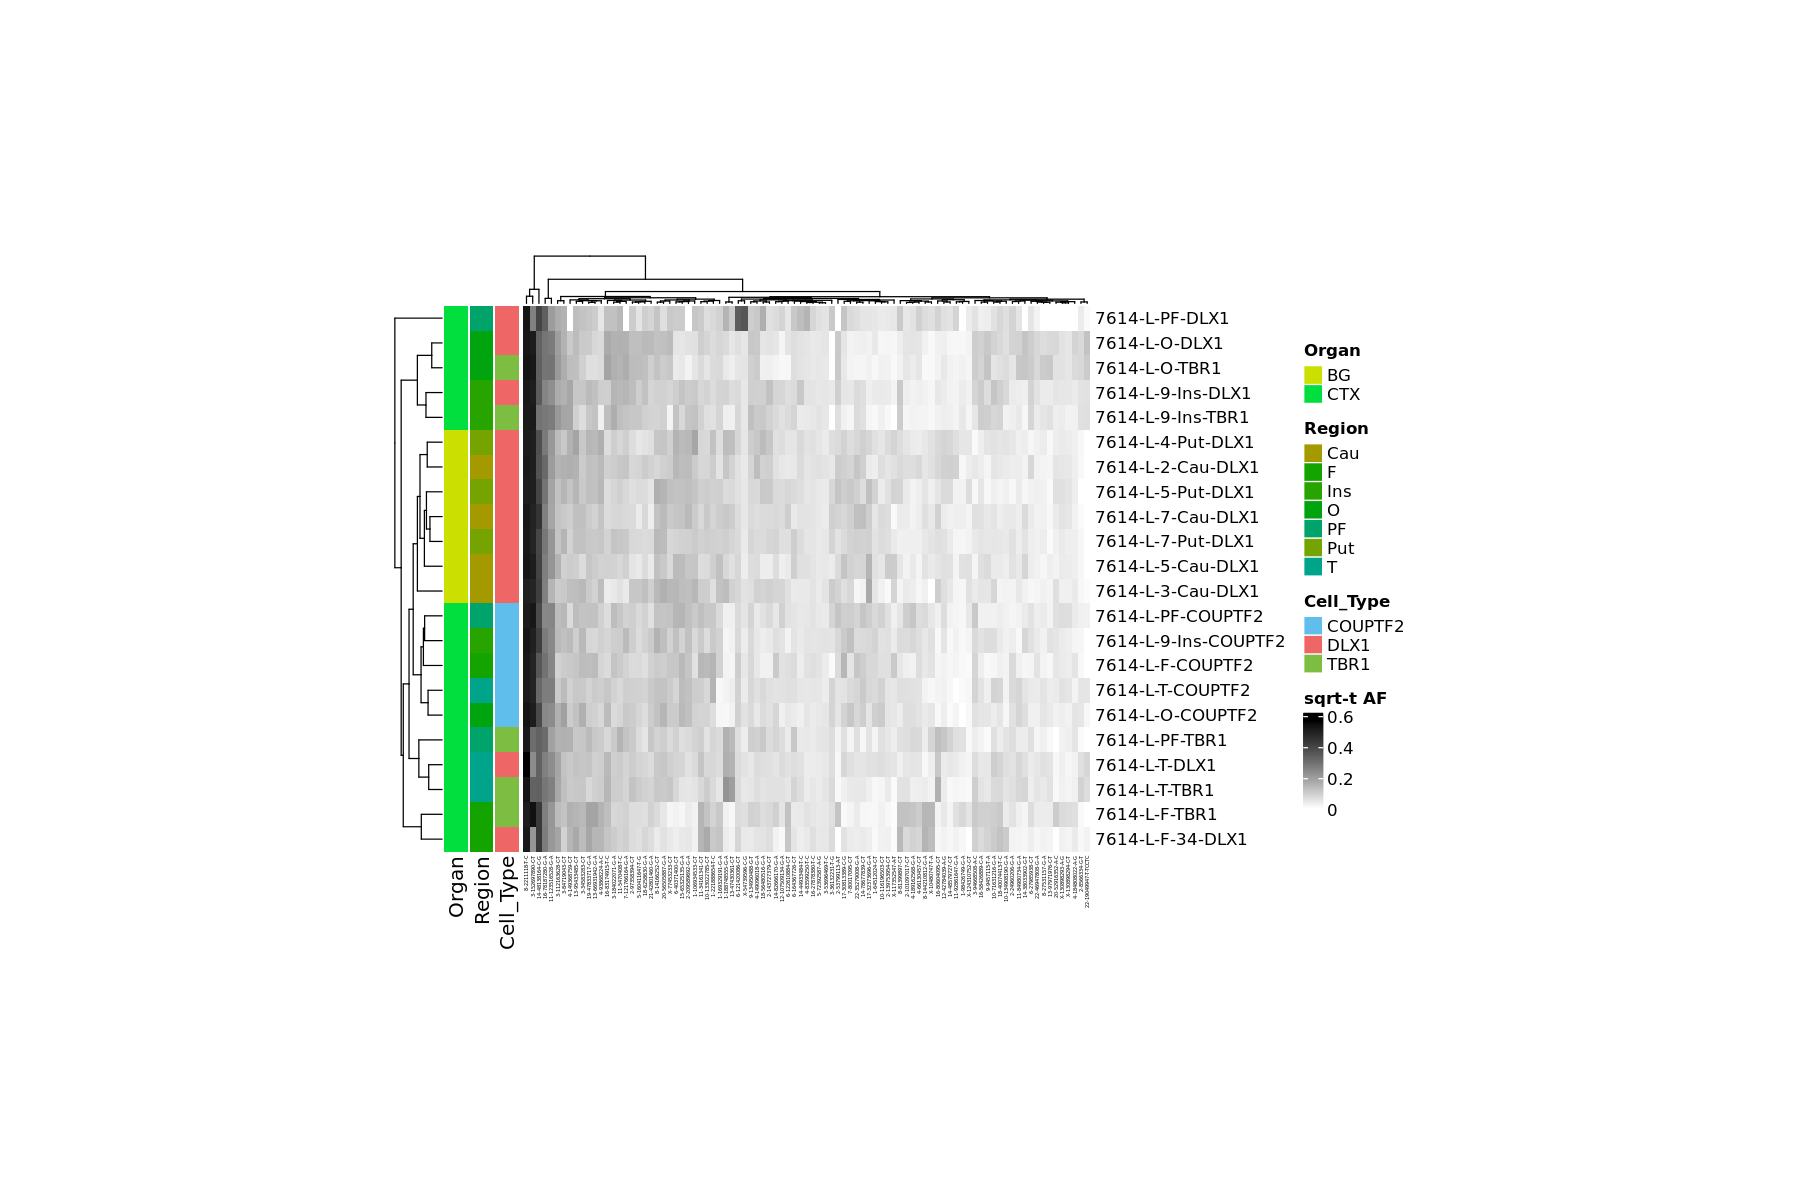

In [9]:
options(repr.plot.width = 15, repr.plot.height = 10)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "sqrt-t AF",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(12, "cm"),
        heatmap_height = unit(14, "cm")) 
p

# Bias plot with sorted nuclei data

In [48]:
working_variants<-rownames(variant_list[variant_list$sample_number_presented>0,])
aaa <- subset(melt_mtcars, Organ %in% c('CTX') & Cell_Type %in% c("COUPTF2"))
bbb <- subset(melt_mtcars, Organ %in% c('CTX') & Cell_Type %in% c("TBR1"))
ccc <- subset(melt_mtcars, Organ %in% c('BG') & Cell_Type %in% c("DLX1"))
length(working_variants)
sum(aaa$MAF, na.rm = TRUE)/length(aaa$MAF)
sum(bbb$MAF, na.rm = TRUE)/length(bbb$MAF)
sum(ccc$MAF, na.rm = TRUE)/length(ccc$MAF)

delta<-data.frame()
for (i in 1:length(working_variants)){
    xx<-subset(aaa, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(bbb, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,1]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

for (i in 1:length(working_variants)){
    xx<-subset(aaa, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(ccc, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,2]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }
delta<-na.omit(delta)

[1] 120

[1] 0.08602761

[1] 0.08553373

[1] 0.08805774

In [49]:
mean(delta[,1])
mean(delta[,2])
SEM_X<-sd(delta[,1]) / sqrt(length(delta[,1]))
SEM_Y<-sd(delta[,2]) / sqrt(length(delta[,2]))
lowerX<-mean(delta[,1])-SEM_X
upperX<-mean(delta[,1])+SEM_X
lowerY<-mean(delta[,2])-SEM_Y
upperY<-mean(delta[,2])+SEM_Y

lowerX
lowerY

upperX
upperY

[1] 0.2738802

[1] 0.2178816

[1] 0.2509577

[1] 0.1961357

[1] 0.2968026

[1] 0.2396274

png 
  2

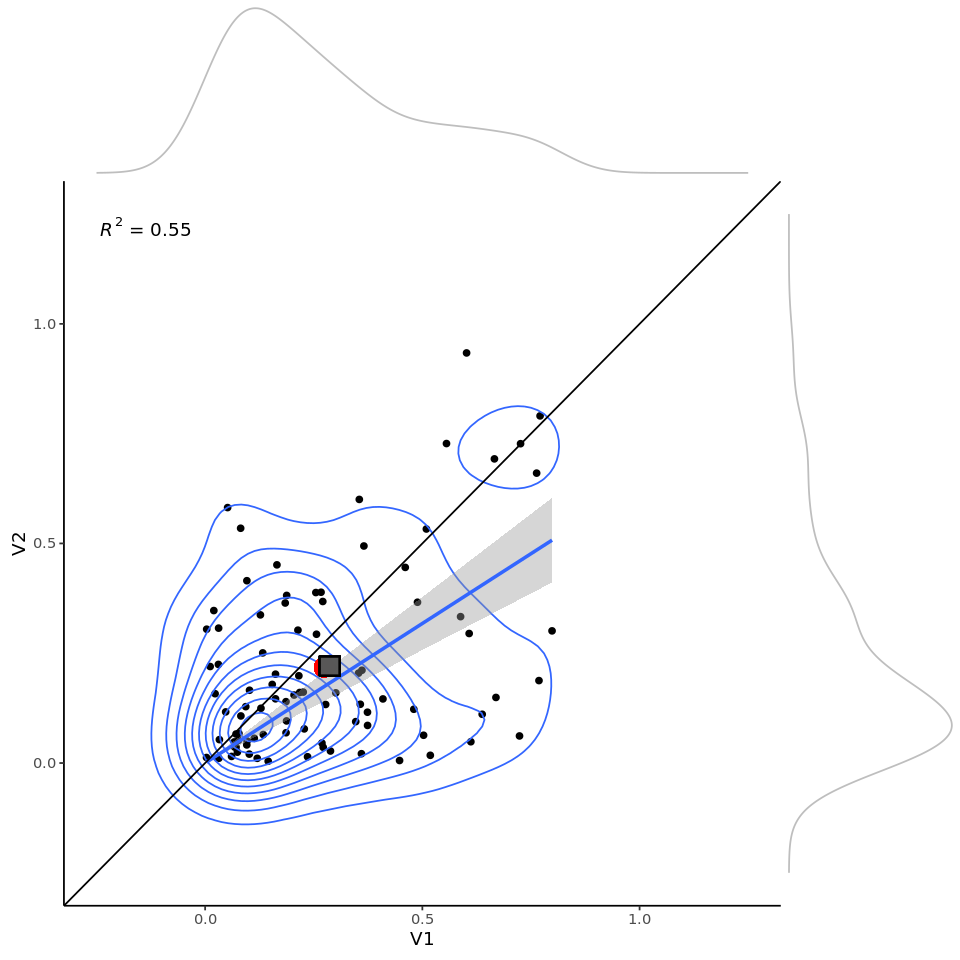

In [50]:
options(repr.plot.width = 8, repr.plot.height = 8)
formula <- y ~ x+0
p<-ggplot(delta, aes(x=V1, y=V2)) + geom_point()+xlim(-0.25,1.25)+ylim(-0.25,1.25)+theme_classic()+
    geom_density_2d()+stat_smooth(method = "lm", formula = y ~ x+0, geom = "smooth")+geom_abline(slope=1, intercept=0)+stat_poly_eq(formula = y ~ x+0,method = "lm")+
    geom_point(x = mean(delta[,1]), y = mean(delta[,2]), aes(x, y), size = 5, color = "red")+
    geom_rect(mapping=aes(xmin=0.264068276257494, xmax=0.309040825451685, ymin=0.199466300480847, ymax=0.241978521971209), color="black", alpha=0.5)
ggMarginal(p, color="grey", size=4)
pdf(file="7614_COUPTF2_origin_plot.pdf",height=8,width=8)
ggMarginal(p, color="grey", size=4)
dev.off()    

In [51]:
nrow(delta[delta[,1]>delta[,2],])
nrow(delta[delta[,1]<delta[,2],])

[1] 56

[1] 35

In [52]:
working_variants<-rownames(variant_list[variant_list$sample_number_presented>0,])
aaa <- subset(melt_mtcars, Organ %in% c('CTX') & Cell_Type %in% c("DLX1"))
bbb <- subset(melt_mtcars, Organ %in% c('CTX') & Cell_Type %in% c("TBR1"))
ccc <- subset(melt_mtcars, Organ %in% c('BG') & Cell_Type %in% c("DLX1"))
length(working_variants)
sum(aaa$MAF, na.rm = TRUE)/length(aaa$MAF)
sum(bbb$MAF, na.rm = TRUE)/length(bbb$MAF)
sum(ccc$MAF, na.rm = TRUE)/length(ccc$MAF)

delta<-data.frame()
for (i in 1:length(working_variants)){
    xx<-subset(aaa, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(bbb, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,1]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

for (i in 1:length(working_variants)){
    xx<-subset(aaa, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(ccc, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,2]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }
delta<-na.omit(delta)

[1] 120

[1] 0.08830743

[1] 0.08553373

[1] 0.08805774

In [53]:
mean(delta[,1])
mean(delta[,2])
SEM_X<-sd(delta[,1]) / sqrt(length(delta[,1]))
SEM_Y<-sd(delta[,2]) / sqrt(length(delta[,2]))
lowerX<-mean(delta[,1])-SEM_X
upperX<-mean(delta[,1])+SEM_X
lowerY<-mean(delta[,2])-SEM_Y
upperY<-mean(delta[,2])+SEM_Y

lowerX
lowerY

upperX
upperY

[1] 0.164916

[1] 0.2718052

[1] 0.1495252

[1] 0.2517089

[1] 0.1803068

[1] 0.2919015

png 
  2

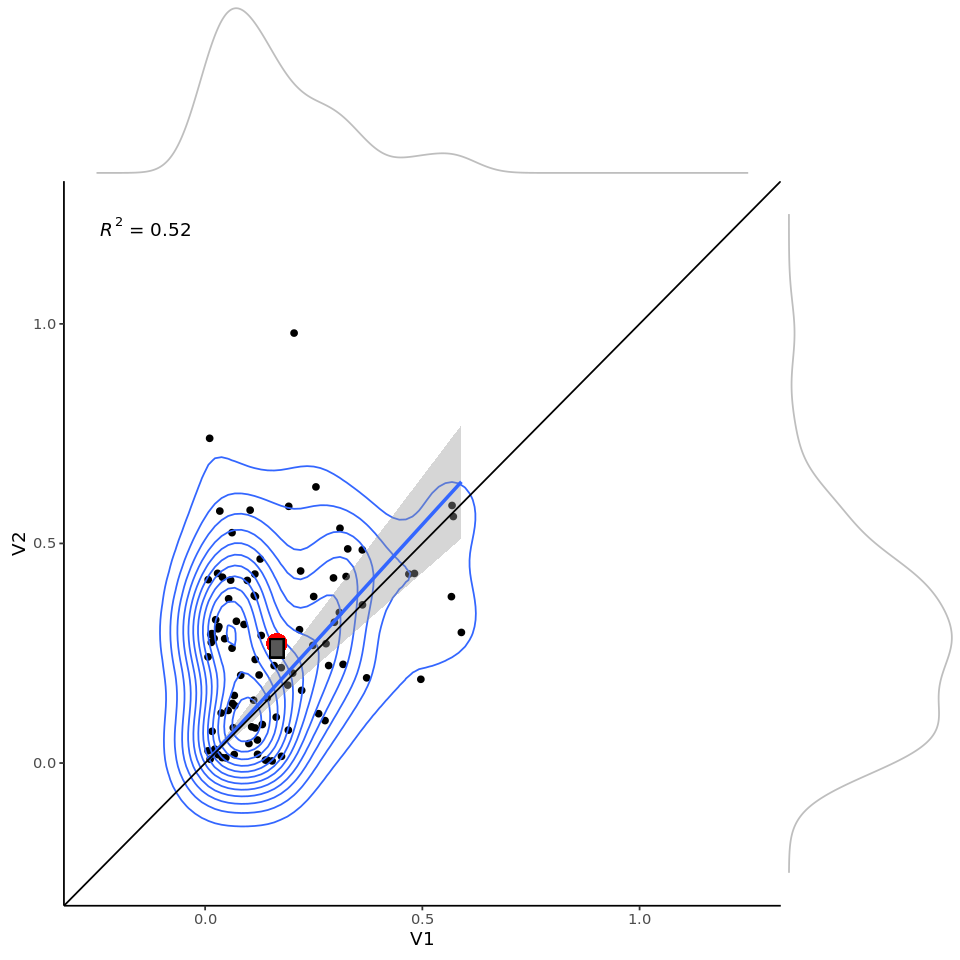

In [54]:
options(repr.plot.width = 8, repr.plot.height = 8)
formula <- y ~ x+0
p<-ggplot(delta, aes(x=V1, y=V2)) + geom_point()+xlim(-0.25,1.25)+ylim(-0.25,1.25)+theme_classic()+
    geom_density_2d()+stat_smooth(method = "lm", formula = y ~ x+0, geom = "smooth")+geom_abline(slope=1, intercept=0)+stat_poly_eq(formula = y ~ x+0,method = "lm")+
    geom_point(x = mean(delta[,1]), y = mean(delta[,2]), aes(x, y), size = 5, color = "red")+
    geom_rect(mapping=aes(xmin=0.149525243196929, xmax=0.18030676574834, ymin=0.240856854700207, ymax=0.281954538959038), color="black", alpha=0.5)
ggMarginal(p, color="grey", size=4)
pdf(file="7614_DLX1_origin_plot.pdf",height=8,width=8)
ggMarginal(p, color="grey", size=4)
dev.off()    

In [47]:
nrow(delta[delta[,1]>delta[,2],])
nrow(delta[delta[,1]<delta[,2],])

[1] 29

[1] 49

# COUPTF2 origin bar graph

In [34]:
data<-as.data.frame(c(13,8,6))
colnames(data)<-"number"
rownames(data)<-c("DLX_BR_BGnCOUP_BR_CTX","TBR_BR_CTXnDLX_BR_BG","TBR_BR_CTXnCOUP_BR_CTX")
data

,number
,<dbl>
DLX_BR_BGnCOUP_BR_CTX,13
TBR_BR_CTXnDLX_BR_BG,8
TBR_BR_CTXnCOUP_BR_CTX,6


In [35]:
xxx<-factor(rownames(data), level=c("DLX_BR_BGnCOUP_BR_CTX","TBR_BR_CTXnDLX_BR_BG","TBR_BR_CTXnCOUP_BR_CTX"))
options(repr.plot.width=5,repr.plot.height=6)
p<-ggplot(data=data, aes(x=xxx, y=number, fill=xxx)) +
geom_bar(colour="black",stat='identity')+theme_classic() + labs(x='Variant properties', colour = "Variant properties", fill="Variant properties")+
geom_text(aes(label=data$number, vjust = -0.5, size=2)) + theme(axis.text.x=element_text(angle=45, hjust=1))

In [36]:
pdf(file="7614_COUPTF2_origin_barplot.pdf",height=6,width=5)
p
dev.off()

png 
  2